## Correlation: &thinsp; DOC and frequency of pr (monthly) exceeding 10 mm/day (F_pr10)

In [17]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import skimage.measure as skm
import seaborn as sns
import scipy
from scipy import stats

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

import os
import sys
home = os.path.expanduser("~") + '/Documents'
sys.path.insert(0, '{}/code/phd/functions'.format(home))
from myFuncs import *

plt.rcParams['figure.figsize'] = [10, 7.5]

In [18]:
metrics = [
    'F_pr10'
    ]

data_options= [
    'F_pr10'
    ]

org_options= [
    'rome'
    # 'ni'
    ]

models_cmip5 = [
    # 'IPSL-CM5A-MR', # 1
    # 'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3  no wap data
    # 'bcc-csm1-1',   # 4  only monthly wap (for rcp)
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6  only monthly wap
    # 'HadGEM2-AO',   # 7  only monthly wap
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9  no wap data
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13 only monthly wap
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17 no wap data
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19 only monthly wap
    ]

models_cmip6 = [     
    'TaiESM1',        # 1
    'BCC-CSM2-MR',    # 2
    'FGOALS-g3',      # 3
    'CNRM-CM6-1',     # 4 (different calendar)
    'MIROC6',         # 5
    'MPI-ESM1-2-HR',  # 6 (different calendar)
    'NorESM2-MM',     # 7
    'GFDL-CM4',       # 8
    'CanESM5',        # 9
    'CMCC-ESM2',      # 10
    'UKESM1-0-LL',    # 11
    'MRI-ESM2-0',     # 12
    'CESM2',          # 13
    'NESM3'           # 14
    ]
datasets = models_cmip5 + models_cmip6

timescales = [
    'daily',
    # 'monthly'
    ]

experiments = [
    # 'historical',
    # 'rcp85',
    'ssp585'
    ]

resolutions = [
    # 'original',
    'regridded'
    ]

print('variable:{}, dataset:{}, experiment:{}, resolution:{}'.format(metrics[0], datasets[0], experiments[0], resolutions[0]))
ds = get_metric(metrics[0], datasets[0], experiments[0], home, resolutions[0])
ds

variable:F_pr10, dataset:TaiESM1, experiment:ssp585, resolution:regridded


<xarray.Dataset>
Dimensions:  (time: 360)
Coordinates:
  * time     (time) object 2070-01-31 00:00:00 ... 2099-12-31 00:00:00
Data variables:
    F_pr10   (time) int64 ...
Attributes:
    description:  Number of gridboxes in daily scene exceeding 10 mm/day

In [19]:
data = ds[data_options[0]]
data

<xarray.DataArray 'F_pr10' (time: 360)>
array([308, 239, 265, ..., 267, 251, 379])
Coordinates:
  * time     (time) object 2070-01-31 00:00:00 ... 2099-12-31 00:00:00
Attributes:
    units:    Nb

In [20]:
org = get_metric(org_options[0], datasets[0], experiments[0], home, resolutions[0])[org_options[0]]
org

<xarray.DataArray 'rome' (time: 10950)>
array([ 612680.172879,  606205.080266,  632955.005271, ..., 1370749.610384,
       1012232.546872,  625871.125552])
Coordinates:
  * time     (time) object 2070-01-01 12:00:00 ... 2099-12-31 12:00:00
Attributes:
    units:    km²

In [21]:
regions = [
    'total',
    # 'descent',
    # 'ascent'
    ]

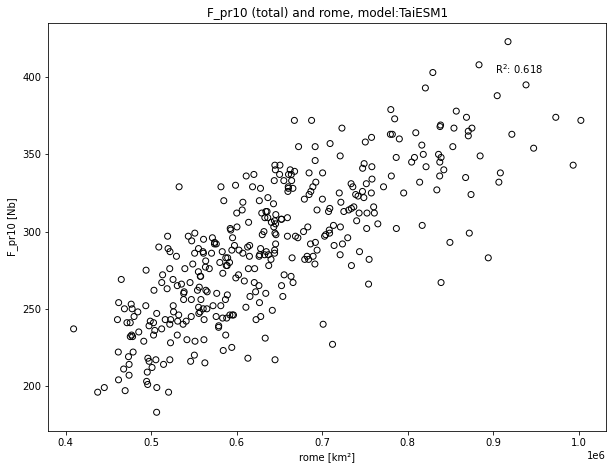

In [22]:
timeMean_options = [
    # 'annual',
    'monthly'
    ]

x = resample_timeMean(org, timeMean_options[0])

data = get_metric(metrics[0], datasets[0], experiments[0], home, resolutions[0])[data_options[0]]
y = resample_timeMean(data, timeMean_options[0])


fig = plt.figure()
ax= fig.add_subplot()
plot_scatter(x, y, ax)
plt.title('{} ({}) and {}, model:{}'.format(data_options[0], regions[0], org_options[0], datasets[0]))
plt.xlabel('{} [{}]'.format(org_options[0], org.units))
plt.ylabel('{} [{}]'.format(data_options[0], data.units))
plt.show()

### comparing datasets

In [23]:
regions = [
    'total',
    # 'descent',
    # 'ascent'
    ]

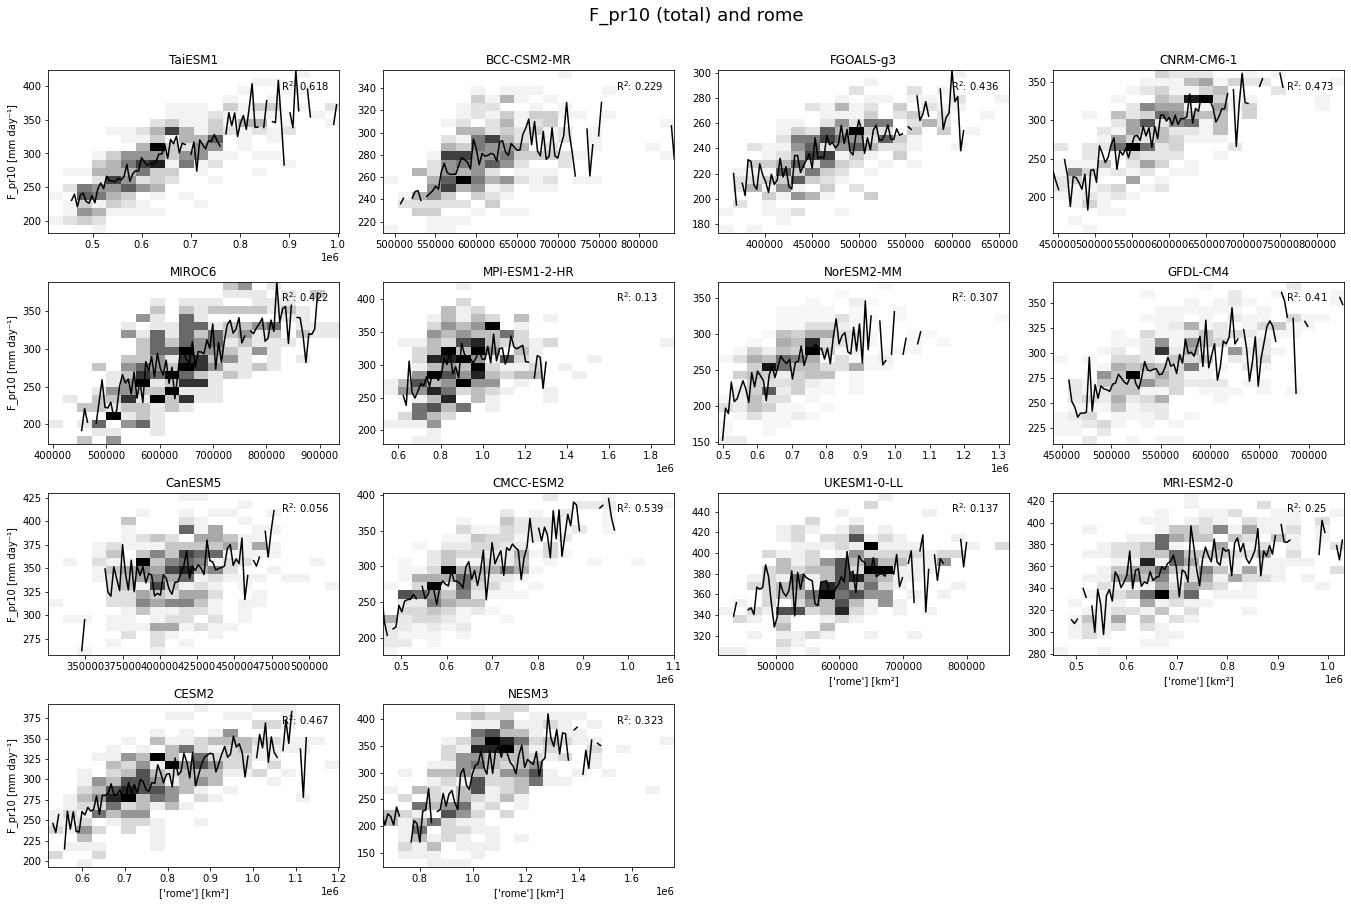

In [24]:
timeMean_options = [
    # 'annual',
    'monthly',
    ]

absolute_xlimits = False
quantile_low = 0
quantile_high = 1
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:
        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        x = resample_timeMean(org, timeMean_options[0])

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))
    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:
        data = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])[data_options[0]]
        data = pick_region(data, dataset, experiments[0], regions[0])
        aWeights = np.cos(np.deg2rad(data.lat))
        y = data.weighted(aWeights).mean(dim=('lat','lon')) 
        y = resample_timeMean(y, timeMean_options[0])
        y = y.assign_coords(time=x.time)
        
        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))
    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = '{} ({}) and {}'.format(data_options[0], regions[0], org_options[0])

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    x = resample_timeMean(org, timeMean_options[0])

    data = get_metric(metrics[0], dataset, experiments[0], home, resolutions[0])[data_options[0]]
    y = resample_timeMean(data, timeMean_options[0])


    # plot_scatter(x, y , ax)
    
    plt.hist2d(x,y,[20,20], cmap ='Greys') #, vmin=0, vmax=300)
    plot_bins(x,y, ax)

    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = '{} [{}]'.format(org_options, org.units)
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], 'mm day' + get_super('-1'))
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

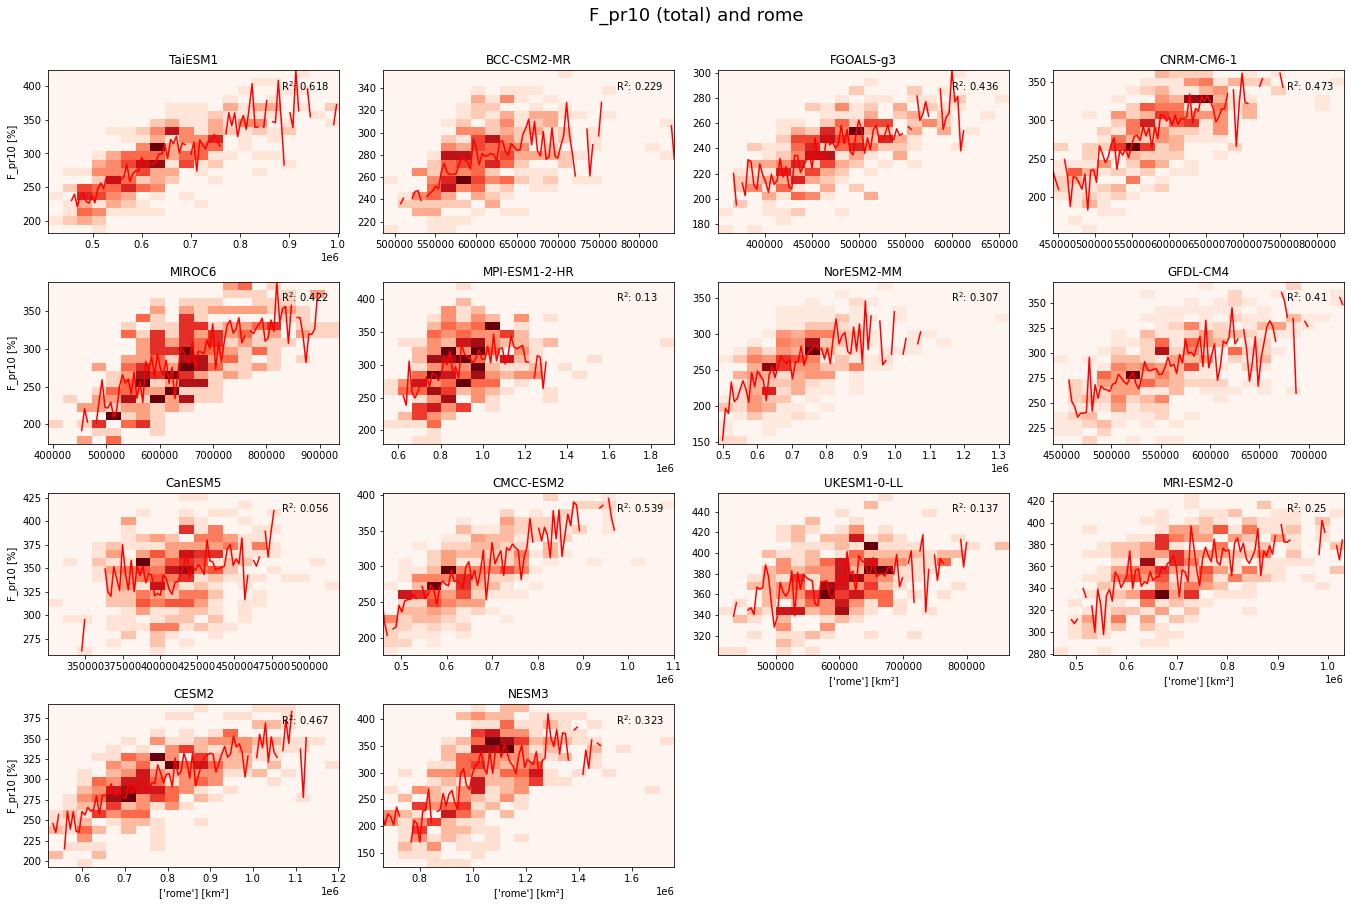

In [25]:
timeMean_options = [
    # 'annual',
    'monthly',
    ]

absolute_xlimits = False
quantile_low = 0
quantile_high = 1
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:
        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        x = resample_timeMean(org, timeMean_options[0])

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))
    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:
        data = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])['hur']
        data = pick_region(data, dataset, experiments[0], regions[0])
        aWeights = np.cos(np.deg2rad(data.lat))
        f = data.weighted(aWeights).mean(dim=('lat','lon')) 
        f = resample_timeMean(f, timeMean_options[0])
        climatology = f.groupby('time.month').mean('time')
        y = f.groupby('time.month') - climatology 

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))
    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = '{} ({}) and {}'.format(data_options[0], regions[0], org_options[0])

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    x = resample_timeMean(org, timeMean_options[0])

    data = get_metric(metrics[0], dataset, experiments[0], home, resolutions[0])[data_options[0]]
    y = resample_timeMean(data, timeMean_options[0])

    # plot_scatter(x, y , ax)
    
    plt.hist2d(x,y,[20,20], cmap = 'Reds')
    plot_bins(x,y, ax, 'r')

    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = '{} [{}]'.format(org_options, org.units)
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], '%')
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

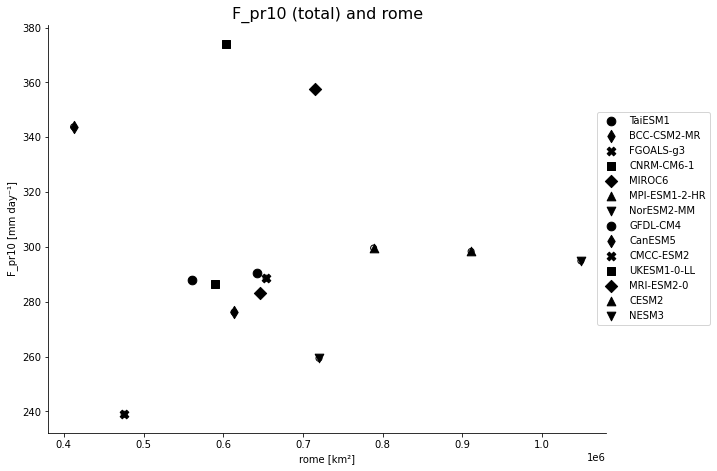

In [26]:
order, colors = orderByTas(False, datasets, experiments[0], resolutions[0])

x= []
y= []
for dataset in datasets:
    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    x_data = org.mean(dim=('time'))
    x = np.append(x, x_data)

    data = get_metric(metrics[0], dataset, experiments[0], home, resolutions[0])[data_options[0]]
    y_data = data.mean(dim=('time'))
    y = np.append(y, y_data)

fig, ax = plt.subplots()
title = '{} ({}) and {}'.format(data_options[0], regions[0], org_options[0])
xlabel = '{} [{}]'.format(org_options[0], org.units)
ylabel = '{} [{}]'.format(data_options[0], 'mm day' + get_super('-1'))

plot_scatter(x,y,ax)

labels = datasets
if labels:
    datasets_order = np.array(datasets)[order]
    labels_order = datasets_order[np.isin(datasets_order, np.array(labels))].tolist()
    for i, label in enumerate(labels_order):
        dataset_idx= datasets.index(label)
        plt.scatter(x[dataset_idx],y[dataset_idx],c=colors[i], marker = markers[i%7], s=75,  label=label)
    plt.legend(bbox_to_anchor=(0.975,0.8))

sns.despine(top=True, right=True, left=False)
plt.title(title, fontsize = 16)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

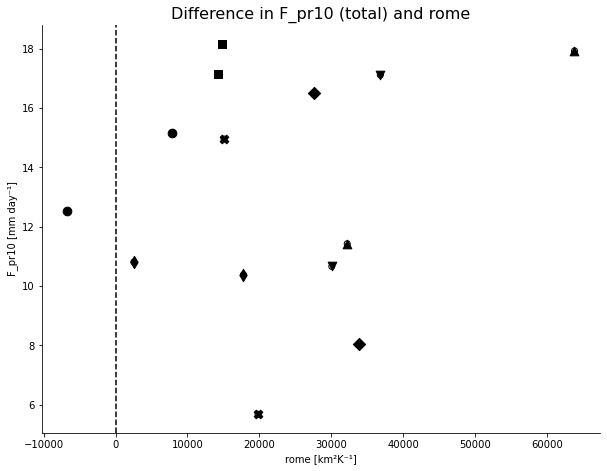

In [28]:
order, colors = orderByTasdiff(False, datasets, models_cmip5, resolutions[0])

x= []
y= []
for dataset in datasets:
    x_historical = get_metric(org_options[0], dataset, experiment = 'historical', resolution=resolutions[0])[org_options[0]].mean(dim=('time'))
    x_rcp = get_metric(org_options[0], dataset, experiment = 'ssp585', resolution=resolutions[0])[org_options[0]].mean(dim=('time'))
    xdiff = x_rcp - x_historical

    fractional_change = False
    if fractional_change:
        xdiff = (xdiff/x_historical)*100

    divide_by_tasdiff = True
    if divide_by_tasdiff:
        tas_historical = get_metric('tas_sMean', dataset, experiment='historical', resolution=resolutions[0])['tas_sMean'].mean(dim='time')
        tas_rcp = get_metric('tas_sMean', dataset, experiment='ssp585', resolution=resolutions[0])['tas_sMean'].mean(dim='time')
        tasdiff = tas_rcp - tas_historical
        xdiff = xdiff/tasdiff
    x = np.append(x, xdiff)


    data = get_metric(metrics[0], dataset, 'historical', home, resolutions[0])[data_options[0]]
    data_historical = data.mean(dim=('time'))

    data = get_metric(metrics[0], dataset,'ssp585', home, resolutions[0])[data_options[0]]
    data_rcp = data.mean(dim=('time'))
    datadiff = data_rcp - data_historical

    fractional_change = False
    if fractional_change:
        datadiff = (datadiff/data_historical)*100

    divide_by_tasdiff = True
    if divide_by_tasdiff:
        tas_historical = get_metric('tas_sMean', dataset, experiment='historical', resolution=resolutions[0])['tas_sMean'].mean(dim='time')
        tas_rcp = get_metric('tas_sMean', dataset, experiment='ssp585', resolution=resolutions[0])['tas_sMean'].mean(dim='time')
        tasdiff = tas_rcp - tas_historical
        datadiff = datadiff/tasdiff
    y = np.append(y, datadiff)


fig, ax = plt.subplots()
title = 'Difference in {} ({}) and {}'.format(data_options[0], regions[0], org_options[0])
xlabel = '{} [{}]'.format(org_options[0], org.units + 'K' + chr(0x207B) + chr(0x00B9))
ylabel = '{} [{}]'.format(data_options[0], 'mm day' + get_super('-1'))

plot_scatter(x,y,ax)

labels = datasets
if labels:
    datasets_order = np.array(datasets)[order]
    labels_order = datasets_order[np.isin(datasets_order, np.array(labels))].tolist()
    for i, label in enumerate(labels_order):
        dataset_idx= datasets.index(label)
        plt.scatter(x[dataset_idx],y[dataset_idx],c=colors[i], marker = markers[i%7], s=75,  label=label)
    
    # plt.legend(bbox_to_anchor=(0.975,0.55))

sns.despine(top=True, right=True, left=False)
plt.axvline(0, color= 'k',  linestyle="--")
# plt.axhline(0, color= 'k',  linestyle="--")
plt.title(title, fontsize = 16)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()